In [1]:
#%%capture
%run ../dca/input/Format.ipynb
import ROOT as root
from array import array
root.gErrorIgnoreLevel = root.kFatal
%jsroot on
root.gStyle.SetOptStat(0)

/home/yoren/.local/lib/python3.10/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


Welcome to JupyROOT 6.30/06


Error in <TUnixSystem::FindDynamicLibrary>: input/logo/PHENIXTools/lib/libLogoPainter.so does not exist in /home/yoren/bnl/ROOT/install/lib:.:/home/yoren/bnl/ROOT/install/lib:/lib/x86_64-linux-gnu/glibc-hwcaps/x86-64-v3:/lib/x86_64-linux-gnu/glibc-hwcaps/x86-64-v2:/lib/x86_64-linux-gnu/tls/haswell/x86_64:/lib/x86_64-linux-gnu/tls/haswell:/lib/x86_64-linux-gnu/tls/x86_64:/lib/x86_64-linux-gnu/tls:/lib/x86_64-linux-gnu/haswell/x86_64:/lib/x86_64-linux-gnu/haswell:/lib/x86_64-linux-gnu/x86_64:/lib/x86_64-linux-gnu:/usr/lib/x86_64-linux-gnu/glibc-hwcaps/x86-64-v3:/usr/lib/x86_64-linux-gnu/glibc-hwcaps/x86-64-v2:/usr/lib/x86_64-linux-gnu/tls/haswell/x86_64:/usr/lib/x86_64-linux-gnu/tls/haswell:/usr/lib/x86_64-linux-gnu/tls/x86_64:/usr/lib/x86_64-linux-gnu/tls:/usr/lib/x86_64-linux-gnu/haswell/x86_64:/usr/lib/x86_64-linux-gnu/haswell:/usr/lib/x86_64-linux-gnu/x86_64:/usr/lib/x86_64-linux-gnu:/lib/glibc-hwcaps/x86-64-v3:/lib/glibc-hwcaps/x86-64-v2:/lib/tls/haswell/x86_64:/lib/tls/haswell:/lib

In [2]:
main_val = 293
main_err = 43
reco_eff_var = [293,299,274,265]#main, pure sim, only sub, pure reco
reco_eff_err = [43, 45, 49, 35]
mass_var =[340,308,293,289,287]#+2 % bg, +1, 0 , -1, -2
mass_err = [100, 57, 38, 36, 33]
cut_var = [293,290,263, 270] #main, cut1, cut2, cut3
cut_err = [43, 37, 39, 38]


In [3]:
#!/usr/bin/env python3
import ROOT as root
import numpy as np
import math

# ================================
# Input: your T values + stat errs
# ================================
main_val = 293.0
main_err = 43.0

reco_eff_var = [293, 299, 274, 265]    # main, pure sim, only sub, pure reco
reco_eff_err = [43, 45, 49, 35]

mass_var = [340, 308, 293, 289, 287]   # +2% bg, +1, 0, -1, -2
mass_err = [100, 57, 38, 36, 33]

cut_var = [293, 290, 263, 310]         # main, cut1, cut2, cut3
cut_err = [43, 37, 39, 40]

# --------------------------------
# Systematic estimators per source
# --------------------------------
def syst_estimators(vals, nominal):
    vals = np.asarray(vals, dtype=float)
    d = vals - nominal

    # asymmetric envelope
    dplus  = float(np.max(np.clip(d, 0, None)))
    dminus = float(np.max(np.clip(-d, 0, None)))

    # symmetric options
    max_abs   = float(np.max(np.abs(d)))
    std       = float(np.std(vals, ddof=1)) if len(vals) > 1 else 0.0
    half_rng  = float(0.5 * (np.max(vals) - np.min(vals)))
    unif_rng  = float((np.max(vals) - np.min(vals)) / math.sqrt(12.0))

    return {
        "asym_plus": dplus,
        "asym_minus": dminus,
        "sym_maxabs": max_abs,
        "sym_std": std,
        "sym_halfrange": half_rng,
        "sym_uniform": unif_rng
    }

def quad(xs):
    return float(math.sqrt(sum(x*x for x in xs)))

sources = {
    "Reco/eff": (reco_eff_var, reco_eff_err, root.kBlue+1, 20),
    "Mass/BG":  (mass_var,     mass_err,     root.kRed+1,  21),
    "Cuts":     (cut_var,      cut_err,      root.kMagenta+1, 22),
}

syst = {name: syst_estimators(v, main_val) for name, (v, e, c, m) in sources.items()}

# Combine orthogonal sources in quadrature
syst_plus  = quad([syst[n]["asym_plus"]  for n in syst])
syst_minus = quad([syst[n]["asym_minus"] for n in syst])

sym_maxabs    = quad([syst[n]["sym_maxabs"]    for n in syst])
sym_std       = quad([syst[n]["sym_std"]       for n in syst])
sym_halfrange = quad([syst[n]["sym_halfrange"] for n in syst])
sym_uniform   = quad([syst[n]["sym_uniform"]   for n in syst])

# --------------------------------
# Print summary
# --------------------------------
print("\n=== Nominal ===")
print(f"T = {main_val:.1f} ± {main_err:.1f} (stat)")

print("\n=== Per-source systematics ===")
for name in syst:
    s = syst[name]
    print(f"\n{name}:")
    print(f"  asym envelope:  +{s['asym_plus']:.2f} / -{s['asym_minus']:.2f}")
    print(f"  sym max(|Δ|):   {s['sym_maxabs']:.2f}")
    print(f"  sym std(vals):  {s['sym_std']:.2f}")
    print(f"  sym (max-min)/2:{s['sym_halfrange']:.2f}")
    print(f"  sym (range/√12):{s['sym_uniform']:.2f}")



=== Nominal ===
T = 293.0 ± 43.0 (stat)

=== Per-source systematics ===

Reco/eff:
  asym envelope:  +6.00 / -28.00
  sym max(|Δ|):   28.00
  sym std(vals):  15.92
  sym (max-min)/2:17.00
  sym (range/√12):9.81

Mass/BG:
  asym envelope:  +47.00 / -6.00
  sym max(|Δ|):   47.00
  sym std(vals):  22.05
  sym (max-min)/2:26.50
  sym (range/√12):15.30

Cuts:
  asym envelope:  +17.00 / -30.00
  sym max(|Δ|):   30.00
  sym std(vals):  19.44
  sym (max-min)/2:23.50
  sym (range/√12):13.57


In [4]:
print("\n=== Combined (quadrature across sources) ===")
print(f"Asym syst:  +{syst_plus:.2f} / -{syst_minus:.2f}")
print(f"Sym syst (maxabs):        {sym_maxabs:.2f}")
print(f"Sym syst (std):           {sym_std:.2f}")
print(f"Sym syst ((max-min)/2):   {sym_halfrange:.2f}")
print(f"Sym syst ((max-min)/√12): {sym_uniform:.2f}")

print("\nFinal report suggestion:")
print(f"T = {main_val:.0f} ± {main_err:.0f} (stat) ^{{+{syst_plus:.0f}}}_{{-{syst_minus:.0f}}} (syst)")


=== Combined (quadrature across sources) ===
Asym syst:  +50.34 / -41.47
Sym syst (maxabs):        62.39
Sym syst (std):           33.43
Sym syst ((max-min)/2):   39.29
Sym syst ((max-min)/√12): 22.68

Final report suggestion:
T = 293 ± 43 (stat) ^{+50}_{-41} (syst)


In [5]:

# --------------------------------
# ROOT styling
# --------------------------------
root.gStyle.SetOptStat(0)

def make_cat_graph(x0, yvals, yerrs, color, marker, xstep=0.18):
    yvals = np.asarray(yvals, dtype=float)
    yerrs = np.asarray(yerrs, dtype=float)
    n = len(yvals)
    xs = x0 + (np.arange(n) - 0.5*(n-1))*xstep

    gr = root.TGraphErrors(n)
    for i in range(n):
        gr.SetPoint(i, float(xs[i]), float(yvals[i]))
        gr.SetPointError(i, 0.0, float(yerrs[i]))
    gr.SetMarkerStyle(marker)
    gr.SetMarkerSize(1.6)
    gr.SetMarkerColor(color)
    gr.SetLineColor(color)
    gr.SetLineWidth(2)
    return gr, xs

def draw_asym_syst_band(x, y, yplus, yminus, fill_color, alpha=0.25, xhalfwidth=0.12):
    g = root.TGraphAsymmErrors(1)
    g.SetPoint(0, x, y)
    g.SetPointError(0, xhalfwidth, xhalfwidth, yminus, yplus)
    g.SetFillColorAlpha(fill_color, alpha)
    g.SetLineColorAlpha(fill_color, 0.8)
    g.SetMarkerSize(0)
    g.Draw("2 same")
    return g


In [14]:

# --------------------------------
# Plot 1: variations with stat errs
# --------------------------------
c1 = root.TCanvas("c_variations", "T variations (stat errors)", 1100, 650)
c1.SetLeftMargin(0.10)
c1.SetBottomMargin(0.16)

x_positions = {"Reco/eff": 1.0, "Mass/BG": 2.5, "Cuts": 4.0}

all_vals = np.array(reco_eff_var + mass_var + cut_var, dtype=float)
ymin = 200
ymax = 400

frame = root.TH2F("frame_vars", "; ;T [MeV]", 10, 0.2, 4.8, 100, ymin, ymax)
frame.GetXaxis().SetLabelSize(0)
frame.GetYaxis().SetTitleOffset(0.95)
frame.Draw()

graphs = {}
for name, (vals, errs, color, marker) in sources.items():
    gr, xs = make_cat_graph(x_positions[name], vals, errs, color, marker)
    graphs[name] = gr
    gr.Draw("P same")

# nominal line
line = root.TLine(0.25, main_val, 4.75, main_val)
line.SetLineStyle(2)
line.SetLineWidth(2)
line.SetLineColor(root.kGray+2)
line.Draw("same")

# category labels
lab = root.TLatex()
lab.SetTextSize(0.050)
lab.SetTextAlign(22)
lab.DrawLatex(x_positions["Reco/eff"], ymin + 0.04*(ymax-ymin), "Reco/eff")
lab.DrawLatex(x_positions["Mass/BG"],  ymin + 0.04*(ymax-ymin), "Mass/BG")
lab.DrawLatex(x_positions["Cuts"],     ymin + 0.04*(ymax-ymin), "Cuts")

leg1 = root.TLegend(0.70, 0.70, 0.95, 0.93)
leg1.SetBorderSize(0)
leg1.SetFillStyle(0)
for name in graphs:
    leg1.AddEntry(graphs[name], f"{name} variations", "p")
leg1.AddEntry(line, "Nominal", "l")
leg1.Draw()

#c1.SaveAs("T_variations_stat.pdf")
c1.Draw()



In [12]:
# --------------------------------
# Plot 2: final value with stat + syst band
# --------------------------------
c2 = root.TCanvas("c_final", "Final T with stat and syst", 750, 600)
c2.SetLeftMargin(0.12)
c2.SetBottomMargin(0.14)

ylo = main_val - 3.0*max(main_err, syst_minus, 1.0)
yhi = main_val + 3.0*max(main_err, syst_plus,  1.0)

frame2 = root.TH2F("frame_final", "; ;T [MeV]", 10, 0.0, 1.0, 100, ylo, yhi)
frame2.GetXaxis().SetLabelSize(0)
frame2.GetYaxis().SetTitleOffset(1.0)
frame2.Draw()

# syst band
gband = draw_asym_syst_band(0.5, main_val, syst_plus, syst_minus, root.kGreen+2, alpha=0.25)

# stat point
gstat = root.TGraphErrors(1)
gstat.SetPoint(0, 0.5, main_val)
gstat.SetPointError(0, 0.0, main_err)
gstat.SetMarkerStyle(33)
gstat.SetMarkerSize(2.3)
gstat.SetMarkerColor(root.kGreen+2)
gstat.SetLineColor(root.kGreen+2)
gstat.SetLineWidth(3)
gstat.Draw("P same")

# text
t = root.TLatex()
t.SetNDC(True)
t.SetTextSize(0.045)
t.DrawLatex(0.16, 0.88, f"T = {main_val:.0f} #pm {main_err:.0f} (stat) ^{{+{syst_plus:.0f}}}_{{-{syst_minus:.0f}}} (syst)")
t.SetTextSize(0.040)
t.DrawLatex(0.16, 0.82, f"Sym syst max(|#Delta|): {sym_maxabs:.1f}")
t.DrawLatex(0.16, 0.77, f"Sym syst std: {sym_std:.1f}   |   (max-min)/2: {sym_halfrange:.1f}   |   range/#sqrt{{12}}: {sym_uniform:.1f}")

leg2 = root.TLegend(0.62, 0.72, 0.93, 0.88)
leg2.SetBorderSize(0)
leg2.SetFillStyle(0)
leg2.AddEntry(gstat, "Stat error", "p")
leg2.AddEntry(gband, "Syst band (asym envelope)", "f")
leg2.Draw()

c2.Draw()
#c2.SaveAs("T_final_stat_syst.pdf")
print("\nSaved:")
print("  T_variations_stat.pdf")
print("  T_final_stat_syst.pdf")


Saved:
  T_variations_stat.pdf
  T_final_stat_syst.pdf


In [26]:
import numpy as np
import math

def poisson_pmf_array(lam, nmax=None, tail_cut=1e-12):
    """
    Build Poisson P(n) for n=0..nmax with safe recursion (no factorial overflow).
    Stops when the remaining tail is negligible.
    """
    if nmax is None:
        # wide enough window around the mean
        nmax = int(lam + 10.0 * math.sqrt(lam) + 50)

    P = np.zeros(nmax + 1, dtype=float)

    # Start near the mode and recurse outward for numerical stability
    n0 = int(lam)
    # log P(n0) = -lam + n0*log(lam) - log(n0!)
    logP0 = -lam + n0 * math.log(lam) - math.lgamma(n0 + 1)
    P[n0] = math.exp(logP0)

    # Upwards: P(n+1) = P(n) * lam/(n+1)
    for n in range(n0, nmax):
        P[n + 1] = P[n] * lam / (n + 1)

    # Downwards: P(n-1) = P(n) * n/lam
    for n in range(n0, 0, -1):
        P[n - 1] = P[n] * n / lam

    # Normalize (small numerical drift)
    P /= P.sum()

    # Optional: trim tiny-probability tails (keeps sums stable for logs)
    # Keep bins where cumulative tail is not too tiny
    cdf = np.cumsum(P)
    lo = int(np.searchsorted(cdf, tail_cut))
    hi = int(np.searchsorted(cdf, 1.0 - tail_cut))
    P_trim = P[lo:hi+1]
    n_vals = np.arange(lo, hi+1)

    # Renormalize after trimming
    P_trim /= P_trim.sum()
    return n_vals, P_trim

def entangleness(P):
    """ε = 1 - Σ P(n)^2"""
    return 1.0 - float(np.sum(P * P))

def shannon_entropy(P, base=math.e):
    """S = -Σ P log P (ignore zero bins)"""
    Pnz = P[P > 0]
    S = -float(np.sum(Pnz * np.log(Pnz)))
    if base == 2:
        S /= math.log(2.0)
    elif base != math.e:
        S /= math.log(base)
    return S

if __name__ == "__main__":
    lam = 500.0
    n, P = poisson_pmf_array(lam)

    eps = entangleness(P)
    S_nat = shannon_entropy(P, base=math.e)   # "nats"
    S_bits = shannon_entropy(P, base=2)       # "bits"
    sumsq = float(np.sum(P * P))

    print(f"Poisson mean λ = {lam}")
    print(f"Support used: n in [{n[0]}, {n[-1]}]  (bins={len(n)})")
    print(f"Check normalization ΣP = {P.sum():.12f}")
    print()
    print(f"Σ P(n)^2 = {sumsq:.8e}")
    print(f"Entangleness ε = 1 - ΣP^2 = {eps:.8f}")
    print(f"Shannon entropy S = {S_nat:.6f} nats  ({S_bits:.6f} bits)")

    # Optional: "effective number of states" (Hill number of order 2)
    Neff = 1.0 / sumsq
    print(f"Effective N_eff = 1/ΣP^2 = {Neff:.2f}")


Poisson mean λ = 500.0
Support used: n in [351, 665]  (bins=315)
Check normalization ΣP = 1.000000000000

Σ P(n)^2 = 1.26172405e-02
Entangleness ε = 1 - ΣP^2 = 0.98738276
Shannon entropy S = 4.526076 nats  (6.529747 bits)
Effective N_eff = 1/ΣP^2 = 79.26


In [17]:
import numpy as np
import math

def poisson_pmf_array(lam, nmax=None, tail_cut=1e-12):
    """Return (n_values, P(n)) for a Poisson(lam), built stably via recursion."""
    if nmax is None:
        nmax = int(lam + 10.0 * math.sqrt(lam) + 50)

    P = np.zeros(nmax + 1, dtype=float)

    n0 = int(lam)  # near the mode
    logP0 = -lam + n0 * math.log(lam) - math.lgamma(n0 + 1)
    P[n0] = math.exp(logP0)

    for n in range(n0, nmax):
        P[n + 1] = P[n] * lam / (n + 1)
    for n in range(n0, 0, -1):
        P[n - 1] = P[n] * n / lam

    P /= P.sum()

    # Trim tiny tails to avoid log(0) issues and keep things fast
    cdf = np.cumsum(P)
    lo = int(np.searchsorted(cdf, tail_cut))
    hi = int(np.searchsorted(cdf, 1.0 - tail_cut))
    P = P[lo:hi+1]
    P /= P.sum()
    n_vals = np.arange(lo, hi+1)
    return n_vals, P

def shannon_entropy(P, base=math.e):
    """S = -Σ P log P"""
    Pnz = P[P > 0]
    S = -float(np.sum(Pnz * np.log(Pnz)))
    if base == 2:
        return S / math.log(2.0)
    if base != math.e:
        return S / math.log(base)
    return S

def entangleness(P):
    """ε = 1 - Σ P^2"""
    return 1.0 - float(np.sum(P * P))

lams = [100, 200, 300, 500, 1000]

print("   λ     S (nats)    S (bits)       ε=1-ΣP^2      ΣP^2        N_eff=1/ΣP^2   support[nmin,nmax]")
print("-"*120)
for lam in lams:
    n, P = poisson_pmf_array(float(lam))
    S_nat  = shannon_entropy(P, base=math.e)
    S_bits = shannon_entropy(P, base=2)
    sumsq  = float(np.sum(P*P))
    eps    = 1.0 - sumsq
    Neff   = 1.0 / sumsq
    print(f"{lam:4d}   {S_nat:10.6f}  {S_bits:10.6f}   {eps:12.8f}  {sumsq:10.3e}   {Neff:12.2f}    [{n[0]},{n[-1]}]")


   λ     S (nats)    S (bits)       ε=1-ΣP^2      ΣP^2        N_eff=1/ΣP^2   support[nmin,nmax]
------------------------------------------------------------------------------------------------------------------------
 100     3.720686    5.367815     0.97177284   2.823e-02          35.43    [38,178]
 200     4.067680    5.868421     0.98004664   1.995e-02          50.12    [109,307]
 300     4.270552    6.161104     0.98370985   1.629e-02          61.39    [187,430]
 500     4.526076    6.529747     0.98738276   1.262e-02          79.26    [351,665]
1000     4.872733    7.029867     0.99107882   8.921e-03         112.09    [786,1230]


In [18]:
import numpy as np
import math

def poisson_pmf_array(lam, nmax=None, tail_cut=1e-12):
    """Return (n_values, P(n)) for Poisson(lam), built stably via recursion."""
    if nmax is None:
        nmax = int(lam + 10.0 * math.sqrt(lam) + 50)

    P = np.zeros(nmax + 1, dtype=float)

    n0 = int(lam)  # near the mode
    logP0 = -lam + n0 * math.log(lam) - math.lgamma(n0 + 1)
    P[n0] = math.exp(logP0)

    for n in range(n0, nmax):
        P[n + 1] = P[n] * lam / (n + 1)
    for n in range(n0, 0, -1):
        P[n - 1] = P[n] * n / lam

    P /= P.sum()

    # trim tiny tails (helps log + speed)
    cdf = np.cumsum(P)
    lo = int(np.searchsorted(cdf, tail_cut))
    hi = int(np.searchsorted(cdf, 1.0 - tail_cut))
    P = P[lo:hi+1]
    P /= P.sum()
    n_vals = np.arange(lo, hi+1)
    return n_vals, P

def shannon_entropy(P):
    """S = -Σ P log P  (natural log, 'nats')"""
    Pnz = P[P > 0]
    return -float(np.sum(Pnz * np.log(Pnz)))

# ---- compute S(λ) ----
lams = np.array([100, 200, 300, 500, 1000], dtype=float)
S = []

for lam in lams:
    _, P = poisson_pmf_array(lam)
    S.append(shannon_entropy(P))

S = np.array(S)

print("λ      S (nats)")
print("-"*22)
for lam, Si in zip(lams, S):
    print(f"{int(lam):4d}   {Si:10.6f}")

# ---- fit S = alpha * log(λ) + beta ----
x = np.log(lams)
alpha, beta = np.polyfit(x, S, 1)

# diagnostics
S_fit = alpha * x + beta
resid = S - S_fit
rmse = math.sqrt(float(np.mean(resid**2)))
ss_res = float(np.sum(resid**2))
ss_tot = float(np.sum((S - np.mean(S))**2))
r2 = 1.0 - ss_res/ss_tot if ss_tot > 0 else float("nan")

print("\nFit to  S(λ) = alpha * log(λ) + beta")
print(f"alpha = {alpha:.6f}")
print(f"beta  = {beta:.6f}")
print(f"RMSE  = {rmse:.6e}  (nats)")
print(f"R^2   = {r2:.6f}")

print("\nPoint-by-point check:")
print("λ      S        S_fit     (S-S_fit)")
print("-"*42)
for lam, Si, Sfi, ri in zip(lams, S, S_fit, resid):
    print(f"{int(lam):4d}  {Si:9.6f}  {Sfi:9.6f}  {ri:+.3e}")

# ---- optional: compare to large-λ approximation for Poisson entropy ----
# S ≈ 0.5 * log(2πeλ) - 1/(12λ) - ...
# This implies alpha should be ~ 0.5 for big λ (natural logs).
print("\n(Theory) For large λ:  S ≈ 0.5*log(2πeλ)  => expected alpha ~ 0.5")


λ      S (nats)
----------------------
 100     3.720686
 200     4.067680
 300     4.270552
 500     4.526076
1000     4.872733

Fit to  S(λ) = alpha * log(λ) + beta
alpha = 0.500319
beta  = 1.416751
RMSE  = 8.933718e-05  (nats)
R^2   = 1.000000

Point-by-point check:
λ      S        S_fit     (S-S_fit)
------------------------------------------
 100   3.720686   3.720803  -1.174e-04
 200   4.067680   4.067598  +8.164e-05
 300   4.270552   4.270460  +9.193e-05
 500   4.526076   4.526035  +4.058e-05
1000   4.872733   4.872830  -9.680e-05

(Theory) For large λ:  S ≈ 0.5*log(2πeλ)  => expected alpha ~ 0.5


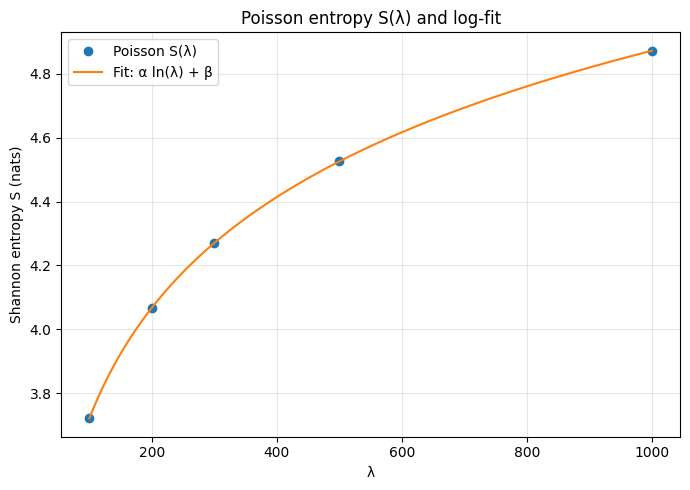

Global fit on all points: alpha = 0.500319, beta = 1.416751


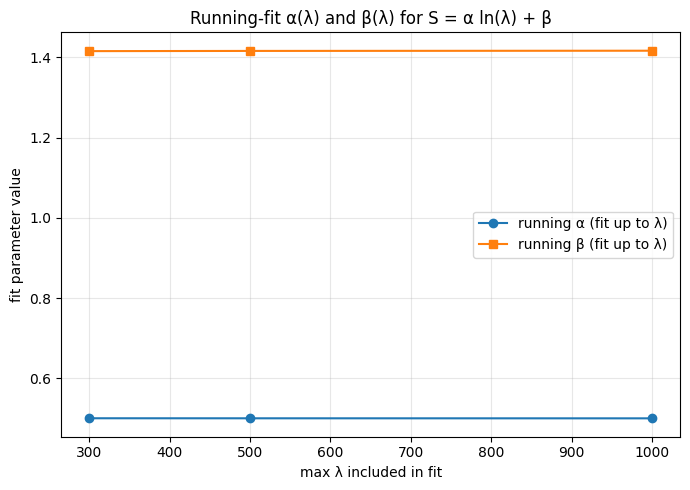


λ    S(nats)
 100   3.720686
 200   4.067680
 300   4.270552
 500   4.526076
1000   4.872733

Running fits (using points up to λ):
λmax   alpha        beta
 300    0.500520    1.415725
 500    0.500420    1.416222
1000    0.500319    1.416751


In [19]:
import numpy as np
import math
import matplotlib.pyplot as plt

# ---------------- Poisson P(n) and entropy ----------------
def poisson_pmf_array(lam, nmax=None, tail_cut=1e-12):
    """
    Return arrays (n_values, P(n)) for Poisson(lam).
    Built stably via recursion around the mode, then trimmed.
    """
    lam = float(lam)
    if nmax is None:
        nmax = int(lam + 10.0 * math.sqrt(lam) + 50)

    P = np.zeros(nmax + 1, dtype=float)

    n0 = int(lam)  # near the mode
    logP0 = -lam + n0 * math.log(lam) - math.lgamma(n0 + 1)
    P[n0] = math.exp(logP0)

    # upward recursion
    for n in range(n0, nmax):
        P[n + 1] = P[n] * lam / (n + 1)

    # downward recursion
    for n in range(n0, 0, -1):
        P[n - 1] = P[n] * n / lam

    # normalize
    P /= P.sum()

    # trim tiny tails (keeps log stable + faster)
    cdf = np.cumsum(P)
    lo = int(np.searchsorted(cdf, tail_cut))
    hi = int(np.searchsorted(cdf, 1.0 - tail_cut))
    P = P[lo:hi+1]
    P /= P.sum()
    n_vals = np.arange(lo, hi+1)
    return n_vals, P

def shannon_entropy(P):
    """S = -Σ P log P (natural log; units = nats)."""
    Pnz = P[P > 0]
    return -float(np.sum(Pnz * np.log(Pnz)))

# ---------------- main: compute S(lambda) ----------------
lams = np.array([100, 200, 300, 500, 1000], dtype=float)

S = np.array([shannon_entropy(poisson_pmf_array(lam)[1]) for lam in lams])
x = np.log(lams)

# Global fit on all points: S = alpha ln(lam) + beta
alpha_all, beta_all = np.polyfit(x, S, 1)
S_fit_all = alpha_all * x + beta_all

# ---------------- alpha/beta "as a function of lambda" ----------------
# Since alpha,beta are fit parameters, to make them vary with lambda
# we do a "running fit": fit using points up to that lambda.
alpha_run = []
beta_run = []
lam_run = []

for i in range(2, len(lams)):  # need at least 2 points to fit a line
    xi = x[:i+1]
    Si = S[:i+1]
    a, b = np.polyfit(xi, Si, 1)
    alpha_run.append(a)
    beta_run.append(b)
    lam_run.append(lams[i])

alpha_run = np.array(alpha_run)
beta_run  = np.array(beta_run)
lam_run   = np.array(lam_run)

# ---------------- Plot 1: S(lambda) + fit ----------------
plt.figure(figsize=(7, 5))
plt.plot(lams, S, 'o', label='Poisson S(λ)')

lam_grid = np.linspace(lams.min(), lams.max(), 400)
plt.plot(lam_grid, alpha_all*np.log(lam_grid) + beta_all, '-', label='Fit: α ln(λ) + β')

plt.xlabel('λ')
plt.ylabel('Shannon entropy S (nats)')
plt.title('Poisson entropy S(λ) and log-fit')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Global fit on all points: alpha = {alpha_all:.6f}, beta = {beta_all:.6f}")

# ---------------- Plot 2: running alpha(λ) and beta(λ) ----------------
plt.figure(figsize=(7, 5))
plt.plot(lam_run, alpha_run, 'o-', label='running α (fit up to λ)')
plt.plot(lam_run, beta_run,  's-', label='running β (fit up to λ)')

plt.xlabel('max λ included in fit')
plt.ylabel('fit parameter value')
plt.title('Running-fit α(λ) and β(λ) for S = α ln(λ) + β')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# ---------------- Optional: print table ----------------
print("\nλ    S(nats)")
for lam, Si in zip(lams, S):
    print(f"{int(lam):4d}  {Si:9.6f}")

print("\nRunning fits (using points up to λ):")
print("λmax   alpha        beta")
for L, a, b in zip(lam_run, alpha_run, beta_run):
    print(f"{int(L):4d}  {a:10.6f}  {b:10.6f}")


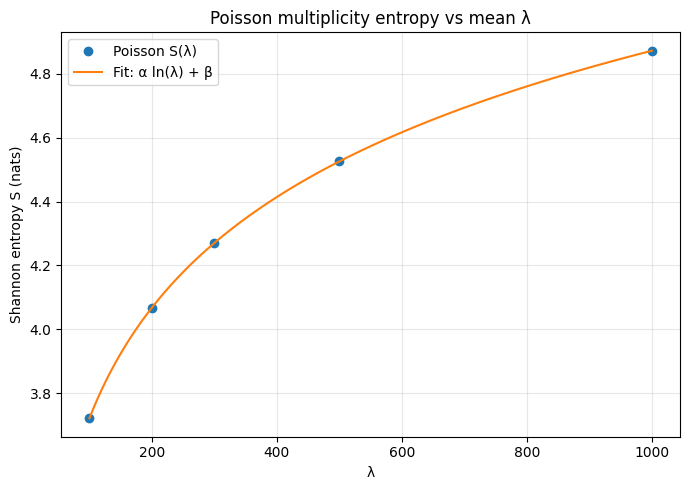

S values (nats):
  λ= 100  S=3.720686
  λ= 200  S=4.067680
  λ= 300  S=4.270552
  λ= 500  S=4.526076
  λ=1000  S=4.872733

Global fit on all points:  S = α ln(λ) + β
  α = 0.500319
  β = 1.416751


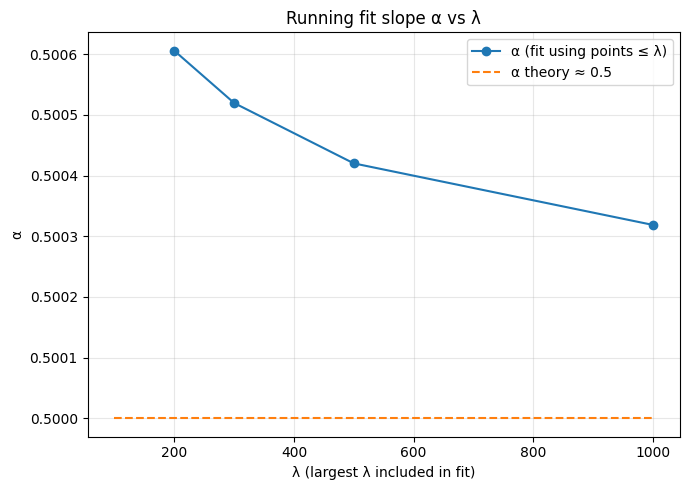

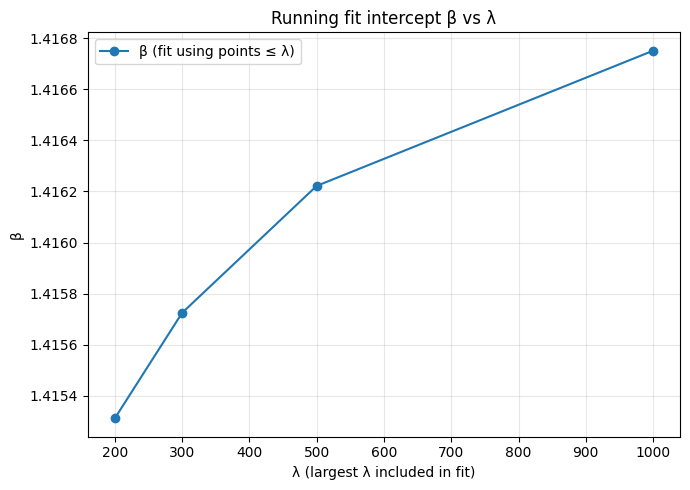

In [20]:
import numpy as np
import math
import matplotlib.pyplot as plt

# ----------------------------
# Poisson P(n) and entropy S
# ----------------------------
def poisson_pmf_array(lam, nmax=None, tail_cut=1e-12):
    """
    Build Poisson P(n) for n=0..nmax stably via recursion (no factorial overflow).
    Returns n_vals, P(n) (trimmed and renormalized).
    """
    lam = float(lam)
    if lam <= 0:
        raise ValueError("lambda must be > 0")

    if nmax is None:
        nmax = int(lam + 10.0 * math.sqrt(lam) + 50)

    P = np.zeros(nmax + 1, dtype=float)

    # start near mode for numerical stability
    n0 = int(lam)
    logP0 = -lam + n0 * math.log(lam) - math.lgamma(n0 + 1)
    P[n0] = math.exp(logP0)

    # upward recursion
    for n in range(n0, nmax):
        P[n + 1] = P[n] * lam / (n + 1)

    # downward recursion
    for n in range(n0, 0, -1):
        P[n - 1] = P[n] * n / lam

    # normalize
    P /= P.sum()

    # trim tiny tails so logs are stable and arrays stay small
    cdf = np.cumsum(P)
    lo = int(np.searchsorted(cdf, tail_cut))
    hi = int(np.searchsorted(cdf, 1.0 - tail_cut))
    P = P[lo:hi+1]
    P /= P.sum()
    n_vals = np.arange(lo, hi+1)
    return n_vals, P

def shannon_entropy(P):
    """S = -Σ P log P  (natural log; units = nats)"""
    Pnz = P[P > 0]
    return -float(np.sum(Pnz * np.log(Pnz)))

def poisson_entropy(lam):
    _, P = poisson_pmf_array(lam)
    return shannon_entropy(P)

# ----------------------------
# Main: compute S(λ) for some λ list
# ----------------------------
lams = np.array([100, 200, 300, 500, 1000], dtype=float)
S = np.array([poisson_entropy(l) for l in lams])

# Fit S = alpha ln(λ) + beta (global fit on all points)
x = np.log(lams)
alpha_global, beta_global = np.polyfit(x, S, 1)

# ----------------------------
# "alpha(λ)" and "beta(λ)" as function of λ:
# Do incremental fits using points up to each λ
# (needs >=2 points)
# ----------------------------
alpha_run = np.full_like(lams, np.nan, dtype=float)
beta_run  = np.full_like(lams, np.nan, dtype=float)

for i in range(1, len(lams)):  # start at 2nd point
    xi = np.log(lams[:i+1])
    yi = S[:i+1]
    a_i, b_i = np.polyfit(xi, yi, 1)
    alpha_run[i] = a_i
    beta_run[i]  = b_i

# Optional: expected asymptotic alpha ~ 0.5 for Poisson at large λ
alpha_theory = 0.5

# ----------------------------
# Plot 1: S vs λ with fit curve
# ----------------------------
plt.figure(figsize=(7, 5))
plt.plot(lams, S, 'o', label='Poisson S(λ)')

lam_grid = np.linspace(lams.min(), lams.max(), 400)
plt.plot(lam_grid, alpha_global*np.log(lam_grid) + beta_global, '-', label='Fit: α ln(λ) + β')

plt.xlabel('λ')
plt.ylabel('Shannon entropy S (nats)')
plt.title('Poisson multiplicity entropy vs mean λ')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("S values (nats):")
for l, s in zip(lams, S):
    print(f"  λ={int(l):4d}  S={s:.6f}")

print(f"\nGlobal fit on all points:  S = α ln(λ) + β")
print(f"  α = {alpha_global:.6f}")
print(f"  β = {beta_global:.6f}")

# ----------------------------
# Plot 2: running alpha(λ) and beta(λ)
# ----------------------------
plt.figure(figsize=(7, 5))
plt.plot(lams, alpha_run, 'o-', label='α (fit using points ≤ λ)')
plt.plot(lams, np.full_like(lams, alpha_theory), '--', label='α theory ≈ 0.5')
plt.xlabel('λ (largest λ included in fit)')
plt.ylabel('α')
plt.title('Running fit slope α vs λ')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(lams, beta_run, 'o-', label='β (fit using points ≤ λ)')
plt.xlabel('λ (largest λ included in fit)')
plt.ylabel('β')
plt.title('Running fit intercept β vs λ')
plt.grid(True, alpha=0.3)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Support used: n in [0, 773]  (bins=774)
Check normalization ΣP = 1.000000000000
Σ P(n)^2 = 1.97997675e-03
Entangleness ε = 0.99802002
Shannon entropy S = 6.241842 nats  (9.005074 bits)
Effective N_eff = 505.06


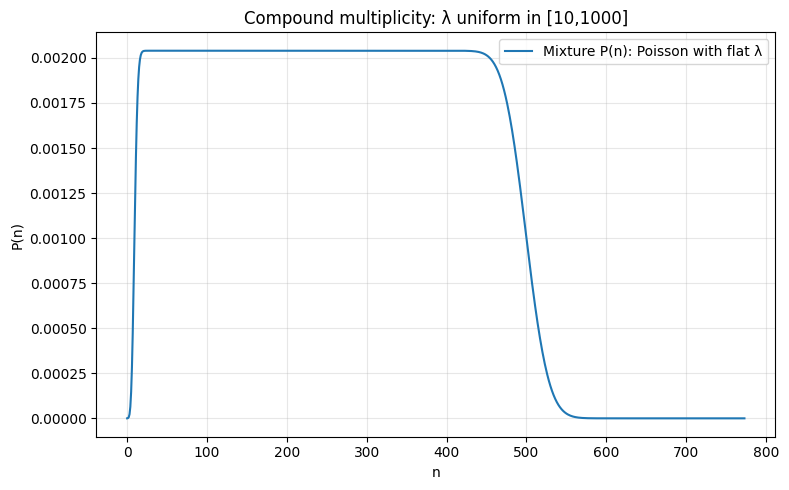

In [29]:
import numpy as np
import math
import matplotlib.pyplot as plt

def poisson_pmf_array(lam, nmax=None, tail_cut=1e-15):
    lam = float(lam)
    if nmax is None:
        nmax = int(lam + 10.0 * math.sqrt(lam) + 50)

    P = np.zeros(nmax + 1, dtype=float)

    n0 = int(lam)
    logP0 = -lam + n0 * math.log(lam) - math.lgamma(n0 + 1)
    P[n0] = math.exp(logP0)

    for n in range(n0, nmax):
        P[n + 1] = P[n] * lam / (n + 1)
    for n in range(n0, 0, -1):
        P[n - 1] = P[n] * n / lam

    P /= P.sum()

    # trim tails
    cdf = np.cumsum(P)
    lo = int(np.searchsorted(cdf, tail_cut, side="left"))
    hi = int(np.searchsorted(cdf, 1.0 - tail_cut, side="left"))  # inclusive-ish boundary
    P_trim = P[lo:hi+1]
    P_trim /= P_trim.sum()

    # IMPORTANT: define n from length (always matches)
    n_vals = np.arange(lo, lo + len(P_trim))
    return n_vals, P_trim

def entangleness(P):
    return 1.0 - float(np.sum(P * P))

def shannon_entropy(P, base=math.e):
    Pnz = P[P > 0]
    S = -float(np.sum(Pnz * np.log(Pnz)))
    if base == 2:
        S /= math.log(2.0)
    elif base != math.e:
        S /= math.log(base)
    return S

def mixture_poisson_flat_lambda(lam_min=10.0, lam_max=1000.0, n_lam=2000,
                                tail_cut=1e-15, nmax=None):
    lam_grid = np.linspace(lam_min, lam_max, int(n_lam))

    if nmax is None:
        nmax = int(lam_max + 10.0 * math.sqrt(lam_max) + 50)

    P_mix = np.zeros(nmax + 1, dtype=float)

    for lam in lam_grid:
        n, P = poisson_pmf_array(lam, nmax=nmax, tail_cut=tail_cut)
        P_mix[n[0]:n[-1] + 1] += P

    # average over lambdas (optional since we renormalize, but conceptually correct)
    P_mix /= len(lam_grid)

    # renormalize
    P_mix /= P_mix.sum()

    # trim global tails
    cdf = np.cumsum(P_mix)
    lo = int(np.searchsorted(cdf, tail_cut, side="left"))
    hi = int(np.searchsorted(cdf, 1.0 - tail_cut, side="left"))
    P_trim = P_mix[lo:hi+1]
    P_trim /= P_trim.sum()

    # IMPORTANT: define n from length (always matches)
    n_vals = np.arange(lo, lo + len(P_trim))
    return n_vals, P_trim

if __name__ == "__main__":
    n, Pmix = mixture_poisson_flat_lambda(10.0, 500.0, n_lam=2000)

    eps = entangleness(Pmix)
    S_nat = shannon_entropy(Pmix, base=math.e)
    S_bits = shannon_entropy(Pmix, base=2)

    sumsq = float(np.sum(Pmix * Pmix))
    Neff = 1.0 / sumsq

    print(f"Support used: n in [{n[0]}, {n[-1]}]  (bins={len(n)})")
    print(f"Check normalization ΣP = {Pmix.sum():.12f}")
    print(f"Σ P(n)^2 = {sumsq:.8e}")
    print(f"Entangleness ε = {eps:.8f}")
    print(f"Shannon entropy S = {S_nat:.6f} nats  ({S_bits:.6f} bits)")
    print(f"Effective N_eff = {Neff:.2f}")

    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(n, Pmix, '-', label='Mixture P(n): Poisson with flat λ')
    plt.xlabel('n')
    plt.ylabel('P(n)')
    plt.title('Compound multiplicity: λ uniform in [10,1000]')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
